In [2]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint
from skimage import measure
from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
from datetime import datetime as dt

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

## current script object
thismodule = sys.modules[__name__]

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

Own modules available: ['casestudy', 'conditionalstats', 'conditionalstats_chunked', 'plot1D', 'plot2D', 'plotCondPDFs', 'lifecycle_mapping']
Own modules available: ['load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'fcns_load_RCEMIP_SAM', 'fcns_multiscale_extremes', 'PrecipGrid', 'fcns_load_DYAMOND_SAM', 'fcns_movie']


In [4]:
# to access segmentation files and simulation outputs
from fcns_load_DYAMOND_SAM import *
# to access TOOCAN objects
from load_TOOCAN_DYAMOND_modif_BF import *
# mapping function
from lifecycle_mapping import *

In [5]:
# load relation table
relation_table = loadRelTable('DYAMOND_SEG')

In [6]:
glob.glob(os.path.join(DIR_TOOCAN_DYAMOND,'*.gz'))

['/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz',
 '/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz']

In [7]:
toocan = loadAllMCSs(DIR_TOOCAN_DYAMOND,load_TOOCAN_DYAMOND)

load /data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160901-20160910.dat.gz
load /data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz
/data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOBAL/2016/FileTracking/TOOCAN-GLOBAL-20160801-20160831.dat.gz


In [8]:
# list of TOOCAN labels, for quicker mapping on toocan list
labels_toocan = [toocan[i].label for i in range(len(toocan))]

In [26]:
# np.sum(np.logical_not(np.in1d(np.arange(np.min(labels_toocan),np.max(labels_toocan)+1),np.array(labels_toocan))))

## DEBUG DUPLICATE TOOCAN LABELS

    #######------------------------------------------------#######
    #   Explore why several toocan labels occur more than once   #
    #######------------------------------------------------#######

Find labels that occur more than once

In [27]:
labels_unique, labels_counts = np.unique(labels_toocan,return_counts=True)
# appear several times
ind_several = np.where(labels_counts > 1)[0]
labels_several = [labels_unique[i] for i in ind_several]
# appear only once
ind_unique = np.where(labels_counts == 1)[0]
labels_valid = [labels_unique[i] for i in ind_unique]
print(labels_several)

[717, 729, 2565, 2903, 3327, 5728, 18298, 18537, 18539, 19218, 20562, 20565, 21368, 23984, 24391, 25621, 26139, 28061, 31542, 33523, 33524, 41189, 43066, 49149, 49717, 52429, 53092, 55540, 62755, 63769, 64271, 64272, 64569, 64570, 64807, 65055, 66285, 67801, 68454, 72417, 74141, 87444, 87445, 87662, 104757, 105566, 113595, 125606, 128417, 141662, 150634, 153266, 156107, 156370, 162780, 171631, 174849, 175108, 180755, 181941, 190433, 192691, 194926, 196100, 199485, 207567, 207965, 218615, 219796, 221569, 224652, 224705, 229157, 229318, 230911, 231223, 239805, 252646, 257068, 258692, 258911, 259047, 260964, 266678, 267866, 267867, 268595, 268660, 276058, 277656, 278325, 280233, 281159, 285952, 287751, 289761, 290318, 297070, 298033, 298073, 298074, 298823, 299352, 299380, 313110, 315861, 318489, 318490, 319169, 319753, 325514, 327698, 328137, 328138, 329491, 331575, 331576, 331627, 343880, 346428, 350434, 352908, 354173, 354445, 355507, 356225, 358379, 358410, 358605, 358978, 360224, 360

Create an array arr of indices such that arr[l] = index (in toocan list) of toocan object with label l 

In [32]:
# Create an array arr of indices such that arr[l] = index (in toocan list) of toocan object with label l


# 0. initiate with nans
inds_labels_all = np.array(np.arange(0,np.nanmax(labels_toocan)+1),dtype=float)
inds_labels_all[0] = np.nan
print(np.sum(np.isnan(inds_labels_all)))

print('-- replace with nans where necessary')
# 1. mask of invalid labels (because duplicate)
# mask_labels_invalid = np.in1d(inds_labels_all,labels_several)
mask_labels_valid = np.in1d(inds_labels_all,labels_valid)
# replace these with nans
# inds_labels_all[mask_labels_invalid] = np.nan
inds_labels_all[~mask_labels_valid] = np.nan
print(np.where(np.isnan(inds_labels_all))[0][:10],'...')

print('-- add correct indices')
# 2. mask toocan labels that are duplicate
# mask_toocan_labels_invalid = np.in1d(labels_toocan,labels_several)
mask_toocan_labels_valid = np.in1d(labels_toocan,labels_valid)
print('size of toocan-style arrays:',len(labels_toocan),len(mask_toocan_labels_valid))
# find indices of valid toocan labels
# ind_toocan_valid = np.where(~mask_toocan_labels_invalid)[0]
ind_toocan_valid = np.where(mask_toocan_labels_valid)[0]
# replace in output index arrays at valid label locations
print('size of ind-style (output) arrays:',len(inds_labels_all),len(mask_labels_invalid))
print('#labels_several:',len(labels_several))
print('#True in mask_labels_invalid:',np.sum(mask_labels_invalid))
print('#True in mask_toocan_labels_valid:',np.sum(mask_toocan_labels_valid))
print('#labels valid in mask_labels_invalid:',np.sum(~mask_labels_invalid))
print(~mask_labels_invalid[710:720],'...')
print('len(ind_toocan_valid)',len(ind_toocan_valid))
print(ind_toocan_valid[0:10])

print()
Nlabs = np.nanmax(labels_toocan)
print('how many labels total:',Nlabs)
print('how many labels to replace by indices:',Nlabs-len(labels_several))
print('how many indices found:',len(labels_toocan)-272)
print()

# inds_labels_all[~mask_labels_invalid][1:] = ind_toocan_valid
inds_labels_all[mask_labels_valid] = ind_toocan_valid
print(np.sum(np.isnan(inds_labels_all)))
# convert to integer
inds_labels_all = np.asarray(inds_labels_all,dtype=int) # nans become large negative integers

### TEST
print()

print('-- TEST')
label_test = 18531
print('example MCS label:',label_test)

print('index of label in TOOCAN list is',inds_labels_all[label_test])

print('toocan label for that index is',labels_toocan[inds_labels_all[label_test]])

1
-- replace with nans where necessary
[  0  52  57  59  81 105 122 124 143 152] ...
-- add correct indices
size of toocan-style arrays: 347106 347106
size of ind-style (output) arrays: 368507 368507
#labels_several: 134
#True in mask_labels_invalid: 134
#True in mask_toocan_labels_valid: 346834
#labels valid in mask_labels_invalid: 368373
[ True  True  True  True  True  True  True False  True  True] ...
len(ind_toocan_valid) 346834
[0 1 2 3 4 5 6 7 8 9]

how many labels total: 368506
how many labels to replace by indices: 368372
how many indices found: 346834

21673

-- TEST
example MCS label: 18531
index of label in TOOCAN list is 17778
toocan label for that index is 311590


In [18]:
# N_occurrences = 2
N_occurrences = 3

labels_unique, labels_counts = np.unique(labels_toocan,return_counts=True)
ind_double = np.where(labels_counts == N_occurrences)[0]
labels_double = [labels_unique[i] for i in ind_double]
labels_double.sort()

print('%d MCS labels occur %d times'%(len(labels_double),N_occurrences))
print()

for label in labels_double:
    # where in toocan list
    ind_label_toocan = np.where(labels_toocan == label)[0]
    
    area_label = 'surfkm2_172Wm2'

    # fig,ax = plt.subplots(ncols=1,figsize=(5,5))
    fig,axs = plt.subplots(ncols=N_occurrences,figsize=(N_occurrences*7,7))
    
    import matplotlib.dates as mdates
    
    # birth time of first MCS
    time_ref_birth = timeIndex2Timedelta(ind_label_toocan[0],0)

    for i_MCS,ax in zip(ind_label_toocan,axs):
    
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d,%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
        
        print('__ label %d, index %d'%(toocan[i_MCS].label,i_MCS))
        # delta between MCS births
        time_birth = timeIndex2Timedelta(i_MCS,0)
        timedelta_birth = time_birth - time_ref_birth

        # print(toocan[i_MCS])
        time = toocan[i_MCS].clusters.Localtime
        time_delta_formatted = np.array([timeIndex2Timedelta(i_MCS,j) for j in range(len(time))])
        time_ref = dt.datetime(year=1970,month=1,day=1)
        time_formatted = time_ref + timedelta_birth + time_delta_formatted
        area_t = np.array(getattr(toocan[i_MCS].clusters,area_lab))
    
        ax.plot(time_formatted,area_t,label=area_lab)
        ax.set_title('MCS label %d, TOOCAN index %d'%(toocan[i_MCS].label,i_MCS))
        ax.set_xlabel('Local Time')
        ax.set_ylabel('Area (km2)')
    
    # rotate x labels if necessary
    plt.gcf().autofmt_xdate()

    # Save
    outdir = os.path.join(DIR_FIG,'duplicates')
    os.makedirs(outdir,exist_ok = True)
    plt.savefig(os.path.join(outdir,'lifecycle_label%d_match_%dMCS.pdf'%(label,N_occurrences)),bbox_inches='tight')
    
    # Do not show
    plt.close()
    

4 MCS labels occur 3 times

__ label 20562, index 90635
__ label 20562, index 90636
__ label 20562, index 90637
__ label 31542, index 101006
__ label 31542, index 101007
__ label 31542, index 101008
__ label 87444, index 152881
__ label 87444, index 152882
__ label 87444, index 152883
__ label 328137, index 33177
__ label 328137, index 33178
__ label 328137, index 33179


In [131]:
def UtimeToRelTableIndex(Utime):
    """Convert Utime (in TOOCAN object for instance) to index in relation table."""

    i_t = np.where(relation_table.UTC == Utime)[0][0]

    return i_t

def getTimeStr(i_t,df=relation_table):

    timestamp = df.path_dyamond[i_t].split('_')[-1]
    delta = dt.timedelta(seconds=int(int(timestamp)*7.5))
    date_t = dt.datetime(2016,8,1) + delta
    time_str = dt.datetime.strftime(date_t,"%h %d %Y, %H:%M")

    return time_str

6 7.0
4 MCS labels occur 3 times

58 83
0.929375 16.63
60


/home/bfildier/.local/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/bfildier/.conda/envs/pyLMD/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


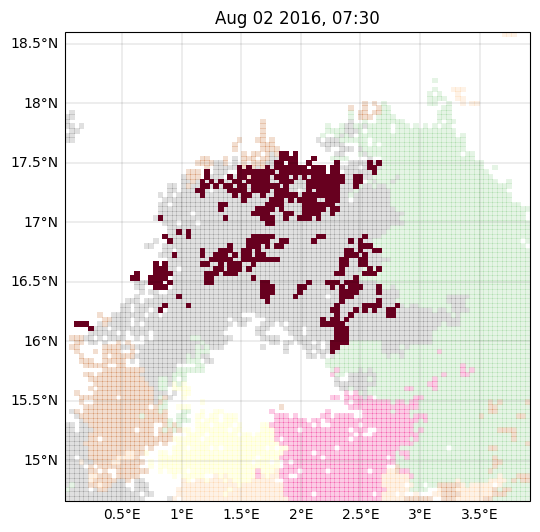

In [134]:
##### MAKE SNAPSHOTS

cmap_mcs = plt.cm.get_cmap('Accent', 10)

# compute figure size
dlon = 5
dlat = 5
Lx_fig = 6
Lx_cbar = 0
Ly_title = 1
Ly_fig = (Lx_fig-Lx_cbar)/dlon*dlat + Ly_title

print(Lx_fig,Ly_fig)

# N_occurrences = 2
N_occurrences = 3

labels_unique, labels_counts = np.unique(labels_toocan,return_counts=True)
ind_double = np.where(labels_counts == N_occurrences)[0]
labels_double = [labels_unique[i] for i in ind_double]
labels_double.sort()

print('%d MCS labels occur %d times'%(len(labels_double),N_occurrences))
print()

for label in labels_double:
    # where in toocan list
    ind_label_toocan = np.where(labels_toocan == label)[0]
    
    area_label = 'surfkm2_172Wm2'

    #-- find time bounds
    i_t_min = np.min([UtimeToRelTableIndex(np.min(toocan[i_MCS].clusters.Utime)) for i_MCS in ind_label_toocan])
    i_t_max = np.max([UtimeToRelTableIndex(np.max(toocan[i_MCS].clusters.Utime)) for i_MCS in ind_label_toocan])
    print(i_t_min,i_t_max)
    
    #-- find mean center of mass
    lon_mean = np.mean(np.hstack([toocan[i_MCS].clusters.lon for i_MCS in ind_label_toocan]))
    lat_mean = np.mean(np.hstack([toocan[i_MCS].clusters.lat for i_MCS in ind_label_toocan]))
    print(lon_mean,lat_mean)
    
    # #-- find spacing between center of mass
    # lon_all = [np.mean(toocan[i_MCS].clusters.lon) for i_MCS in ind_label_toocan]
    # lat_all = [np.mean(toocan[i_MCS].clusters.lat) for i_MCS in ind_label_toocan]
    # print(lon_all,lat_all)
    
    #-- Show image at given t
    # try at midpoint t
    # i_t = int(i_t_min+(i_t_max-i_t_min)/3)
    i_t = i_t_min + 2
    title = getTimeStr(i_t)
    print(i_t)
    
    # initialize figure
    fig = plt.figure(figsize=(Lx_fig,Ly_fig))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    
    slice_lon = slice(lon_mean-3,lon_mean+3)
    slice_lat = slice(lat_mean-2,lat_mean+2)
    
    # load 
    segmask = loadTOOCANSeg(i_t,relation_table)
    lonarray_toocan,latarray_toocan = getCoords2D(segmask,slice_lon,slice_lat)
    img_seg = segmask.sel(longitude=slice_lon,latitude=slice_lat)[0]
    img_seg_modulo10 = img_seg%10
    img_mask_label = ~(img_seg == label)
    img_seg_label = np.ma.masked_array(img_mask_label,img_mask_label)
    
    # mask
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im_MCS = ax.pcolormesh(lonarray_toocan,latarray_toocan,img_seg_modulo10,transform=ccrs.PlateCarree(),cmap=cmap_mcs,alpha=0.2)
        im_label = ax.pcolormesh(lonarray_toocan,latarray_toocan,img_seg_label,transform=ccrs.PlateCarree(),cmap='RdGy',alpha=1)

    # coordinates
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, linestyle='-')
    
    gl.xlabels_top = None
    gl.ylabels_right = None
    
    # labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    
    break

    ##### AUTOMATE FIGURE

In [140]:

def initFigure(i_t0,Lx_fig=15,Ly_fig=4,title=None):
    
    # load data
    segmask = loadTOOCANSeg(i_t,relation_table)
    lonarray_toocan,latarray_toocan = getCoords2D(segmask,slice_lon,slice_lat)
    img_seg = segmask.sel(longitude=slice_lon,latitude=slice_lat)[0]
    img_seg_modulo10 = img_seg%10
    img_seg_label = np.ma.masked_array(~(img_seg == label),img_mask_label)
    
    # initialize figure
    fig = plt.figure(figsize=(Lx_fig,Ly_fig))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

    #- show masks
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        im_MCS = ax.pcolormesh(lonarray_toocan,latarray_toocan,img_seg_modulo10,transform=ccrs.PlateCarree(),cmap=cmap_mcs,alpha=0.2)
        im_label = ax.pcolormesh(lonarray_toocan,latarray_toocan,img_seg_label,transform=ccrs.PlateCarree(),cmap='RdGy',alpha=1)

    # coordinates
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, linestyle='-')    

    # store image placeholders for later updating
    ims = [im_MCS,im_label]

    # delete data and remove from memory
    del segmask
    del img_seg_modulo10
    del img_seg_label
    gc.collect()
    
    # cosmetics
    gl.xlabels_top = None
    gl.ylabels_right = None
    
    # labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)

    
    return fig, ax, ims

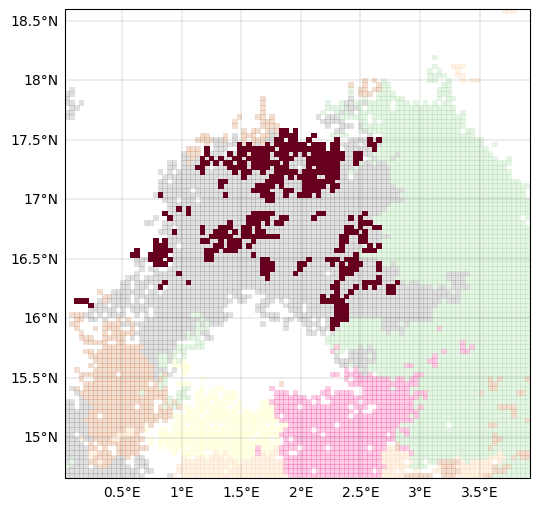

In [141]:
i_t = 60

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    initFigure(i_t,Lx_fig,Ly_fig,title='')

    ##### MAKE MOVIE


In [ ]:
#-- MOVIE -- EDIT

def makeMovie(movie_path):
    
    Nt = len(df)
    
    # -- initialize figure
    
    # first time step
    # i_t0 = j_row_t0 ## EDIT
    
    title_root = 'Day %s'
    # t_str = "%3.2f"%PW_DYAMOND.time.data[0]
    t_str = getTimeStr(i_t0)
    title = title_root%t_str
    
    # initialize
    fig, ax, ims = initFigure(i_t0,Lx_fig,Ly_fig,title=title)
    
    # -- define movie loop
    def updateImage(i_t):
        
        print(i_t,end=' ')
        
        # load data at i_t
        PW_DYAMOND, img_TOOCAN = importData(i_t)
        
        t_str = getTimeStr(i_t)
        
        for slice_lon,i_ims in zip([slice(lon_lim[0],360),slice(0,lon_lim[1])],list(np.arange(2))):
        
            Z = PW_DYAMOND.sel(lon=slice_lon,lat=slice_lat)[0]
            IMG_SEG = img_TOOCAN.sel(longitude=slice_lon,latitude=slice_lat)[0]%10    

            # update images
            ims[i_ims][0].set_array(np.ravel(Z[:-1,:-1].data))
            ims[i_ims][1].set_array(np.ravel(IMG_SEG[:-1,:-1].data))
        
        ax.set_title(title_root%t_str)

        # delete data and remove from memory
        del PW_DYAMOND
        del img_TOOCAN
        del Z
        del IMG_SEG
        gc.collect()
        
        return [ims]
    
    # anim = animation.FuncAnimation(fig, updateImage,
    #                                frames=range(i_t0,i_t0+24), interval=interval, blit=False)
    anim = animation.FuncAnimation(fig, updateImage,
                                   frames=range(j_row_t0,j_row_t0+10), interval=interval, blit=False)

    writer = animation.writers['ffmpeg'](fps=frame_rate)

    anim.save(movie_path,writer=writer,dpi=150,savefig_kwargs={'bbox_inches':'tight'})

In [ ]:
label = 

moviedir = '../movies/'
movie_name = 'toocan_duplicate_label_%s'%
movie_path = os.path.join(moviedir, '%s.mp4'%(movie_name))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    makeMovie(movie_path)